## Looking for the best ratio between labeled and unlabeled images in Self-training with Noisy Student

### Authors: Weiwei Zhan(wz2483) & Yu Huang(yh3019)

* Data: Mnist dataset 

* Model: EfficientNet

* Ratio of unlabelled:labelled in each model fitting process: **1～6**

* Initial Teacher model uses 1,000 images

* **Data augmentation for student model only**

* **Validation size=30% * training size**

* test size: 2000

* Epoch Number: 30 (teacher), 20 (student1), 20(student2)

In [2]:
from __future__ import print_function

import os
import pickle

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from keras.utils import np_utils
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from efficientnet.tfkeras import EfficientNetB0, EfficientNetB7
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings 
warnings.simplefilter(action='ignore')

In [2]:
!pip install opencv-python
!pip install efficientnet
!pip install imgaug

  Using cached opencv_python-4.2.0.34-cp37-cp37m-manylinux1_x86_64.whl (28.2 MB)
  Using cached efficientnet-1.1.0-py3-none-any.whl (18 kB)
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)


In [2]:
keras.__version__, tf.__version__

('2.2.4-tf', '1.13.1')

### 1. Data preprocessing
reference: https://github.com/bjo9280/keras-efficientNet-mnist/blob/master/efficientNet-mnist.ipynb

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Original image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test  = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


# Resized image dimensions
img_size = 32
x_train1 = np.full((x_train.shape[0], img_size, img_size, 3), 0.0)

for i, s in enumerate(x_train):
#     mg = cv2.resize(X_train3[i], (32,32), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    x_train1[i] = img

    
x_test1 = np.full((x_test.shape[0], img_size, img_size, 3), 0.0)
for i, s in enumerate(x_test):
    img = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    x_test1[i] = img

x_train1 = x_train1.astype(np.uint8)
x_test1  = x_test1.astype(np.uint8)

# convert class vectors to binary class matrices
num_classes = 10
y_train1 = keras.utils.to_categorical(y_train, num_classes)
y_test1  = keras.utils.to_categorical(y_test, num_classes)

print('Totally,', x_train1.shape[0],' training samples and ', x_test1.shape[0],' test samples')
# print('Dimensions of input image is: ', x_train1.shape)

Totally, 60000  training samples and  10000  test samples


#### Data preprocessing for teacher model
**Initial size: 1000**

In [4]:
# split data for teacher model
num_label   = 1000
num_unlabel = 0
x_train1, x_unused1, y_train1, y_unused1 = train_test_split(x_train1, y_train1,  train_size=num_label, random_state=31, shuffle=True)
x_valid1, x_unused2, y_valid1, y_unused2 = train_test_split(x_unused1,y_unused1, train_size=int((num_label+num_unlabel)*0.3), random_state=31, shuffle=True)

# validation set in teacher model training could still be used as training set during student model training
del x_unused2, y_unused2

print('Teacher model data preprocessing finished.')
print(x_train1.shape[0], 'train samples;  ',x_valid1.shape[0], 'validation samples')

Teacher model data preprocessing finished.
1000 train samples;   300 validation samples


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


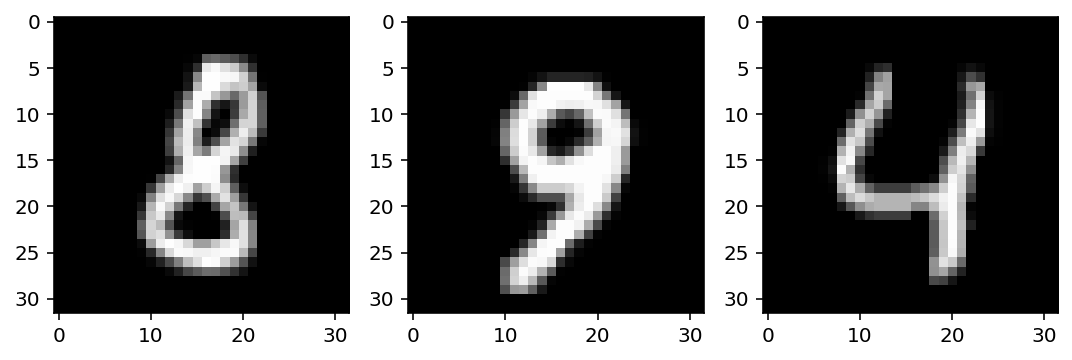

In [5]:
# check the first sample in training set & test set
fig,axes = plt.subplots(figsize=(9,4),ncols=3)
n = 4
axes[0].imshow(x_train1[n])
axes[1].imshow(x_valid1[n])
axes[2].imshow(x_test1[n])
print(y_train1[n],y_valid1[n],y_test1[n])

#### Data augmentation setup
For teacher & validation - Just Scale! No Augmentation!

For student - Augmentation! To change color, brightness, contrast, crop ...

reference:

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

https://imgaug.readthedocs.io/en/latest/source/examples_basics.html

In [6]:
### Data augmentation definition function
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([

    iaa.MultiplyBrightness((0.5, 1.5)),
    # Create an augmenter that takes 20x20 sized crops from the center of images.
    sometimes(iaa.KeepSizeByResize(iaa.CenterCropToFixedSize(height=32, width=32),interpolation="nearest")),
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.8, 1.5), per_channel=True),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
              
    # Apply affine transformations to some of the images
    # - scale/zoom to 80-120% of image height/width (each axis independently)
    # - translate/move by -20 to +20 relative to height/width (per axis)
    # - rotate by -5 to +5 degrees
    # - shear by -8 to +8 degrees
    # - order: use nearest neighbour or bilinear interpolation (fast)
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, #wwz
        rotate=(-20, 20), # 10 wwz
        shear=(-8, 8),
        order=[0, 1]))
],random_order=True) # do all of the above augmentations in random order
    
def augment_student(img):
        seq_det = seq.to_deterministic()
        img     = img.astype(np.uint8)
        aug_image = seq_det.augment_image(img)
        aug_image = aug_image.astype(np.float32)
        aug_image = aug_image/255     
        return aug_image

# only do rescale for teacher model
def augment_teacher(img):
        img     = img.astype(np.float32)
        img     = img/255
        return img
    
# only do rescale for validation
def augment_validation(img):
        img     = img.astype(np.float32)
        img     = img/255
        return img

In [7]:
# define the data generators
aug_teacher = ImageDataGenerator(preprocessing_function=augment_teacher)

aug_student = ImageDataGenerator(preprocessing_function=augment_student)
    
aug_validation = ImageDataGenerator(preprocessing_function=augment_validation)

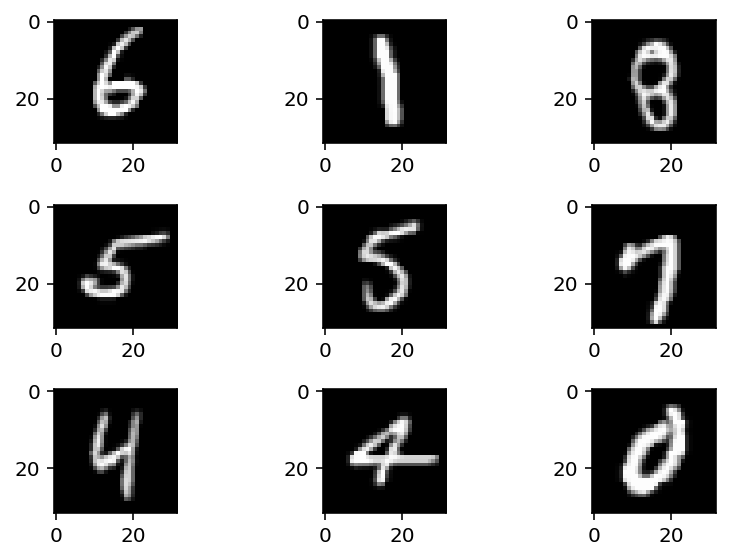

In [8]:
for X_batch, y_batch in aug_teacher.flow(x_train1, y_train1, batch_size=9,seed=3019):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.tight_layout()
    break

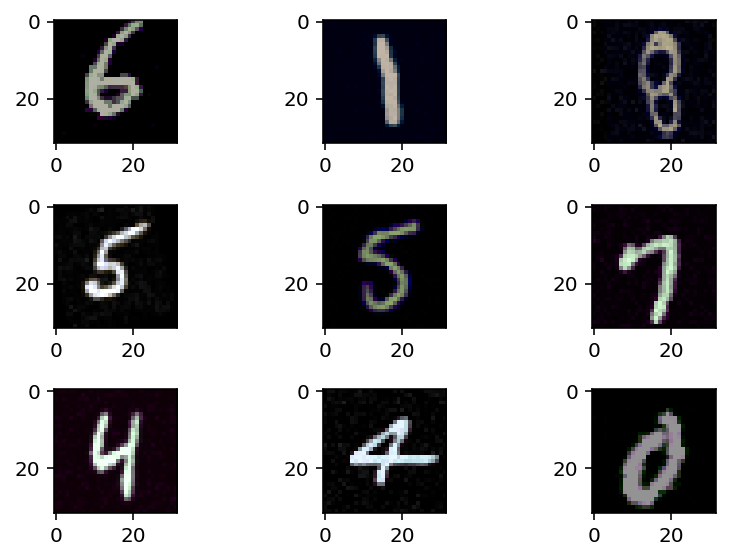

In [9]:
for X_batch, y_batch in aug_student.flow(x_train1, y_train1, batch_size=9,seed=3019):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.tight_layout()
    break

### 2. Build and train teacher model

In [10]:
# a function to build the model
# only one dense layer between the base model and the prediction layer
def build_model(img_size, base_model_type, drop_rate, intermediate_dense_num):
    # loading pretrained model
    if base_model_type == 'ENB0':
        base_model = EfficientNetB0(weights='imagenet',input_shape=(img_size,img_size,3),include_top=False)
    if base_model_type == 'ENB7':
        base_model = EfficientNetB7(weights='imagenet',input_shape=(img_size,img_size,3),include_top=False)
    
    # check if the pre-trained model is trainable:
    for layers in base_model.layers:
        print(layers.trainable)
        break
        
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(drop_rate)(x) # once used 0.2 too but not as good as 0.5
    
    if intermediate_dense_num == 3:
        x = Dense(1024, activation="relu")(x)
        x = Dropout(drop_rate)(x) # once used 0.2 too but not as good as 0.5
        x = Dense(128, activation="relu")(x)
        x = Dropout(drop_rate)(x) # once used 0.2 too but not as good as 0.5
            
    predictions = Dense(units = 10, activation="softmax")(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    return model

In [11]:
# set up some model parameters
img_size        = 32
base_model_type = 'ENB0'
drop_rate       = 0.5
intermediate_dense_num = 1

batch_size    = 128
epochs        = 30
learning_rate = 0.001
model_name = f'teachermodel_1000i_Mnist_{epochs}e_drop05_lr{learning_rate}' 

# build the model and save the model summary 
model = build_model(img_size, base_model_type, drop_rate, intermediate_dense_num)

filename = './models/'+model_name+'summary.txt'

with open(filename,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
True


In [12]:
# Here we use F1-score and categorical_accuracy as evaluation metrics
import keras.backend as K

def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [13]:
#Save the model after every epoch.
from tensorflow.keras.callbacks import ModelCheckpoint,Callback

maxacc_filepath = './models/'+ model_name +'-{epoch:02d}-{val_categorical_accuracy:.2f}-{val_f1_m:.2f}.hdf5' 

checkpoint1 = ModelCheckpoint(filepath=maxacc_filepath, monitor='val_categorical_accuracy',
                              verbose=1, save_best_only=False, period=20) #wwz

callbacks_list = [checkpoint1]

In [ ]:
model.compile(optimizers.RMSprop(lr=learning_rate),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])

H_teacher = model.fit_generator(aug_teacher.flow(x_train1, y_train1, batch_size=batch_size),
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train1) // batch_size,
                        validation_data  = aug_validation.flow(x_valid1, y_valid1, batch_size=batch_size),
                        validation_steps = len(x_valid1)// batch_size,
                        callbacks=callbacks_list,
                        verbose=0) # only get output metrics for validation data  

#### Save the model & training process

In [14]:
def plot_training(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(12,4),ncols=3)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()
    axes[0].set_ylabel('metric')
    axes[0].set_xlabel('epoch number')

    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')
    axes[1].set_xlabel('epoch number')

    axes[2].plot(epochs, f1, 'b')
    axes[2].plot(epochs, val_f1, 'r')
    axes[2].set_title('Training and validation F1 score')
    axes[2].set_xlabel('epoch number')

def save_and_plot(model, model_name, H):
    # save the final model
    model.save("./models/"+model_name+".hdf5")
    
    plot_training(H)
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 220
    plt.savefig('./Figures/'+model_name+'.png')
    
    # save the evolultion process of the metrics during training
    pickle_name = './models/'+model_name+'.pckl'
    os.makedirs(os.path.dirname(pickle_name), exist_ok=True)
    f = open(pickle_name, 'wb')
    pickle.dump(H.history, f)
    f.close()

In [ ]:
save_and_plot(model, model_name, H_teacher)

### 3. Student1 Training

**Data preparation: generate psuedo labels and combine labeled data with unlabeled data** 

In [15]:
def pesodu_label_generator(model_teacher, x_unlabel1):
    teacher_model = load_model("./models/"+model_teacher+".hdf5", custom_objects={"f1_m": f1_m})
    
    # preprocess unlabeled x 
    x_unlabel1 = x_unlabel1.astype('float32')
    x_unlabel1 = x_unlabel1/255.
    
    # Predict psuedo labels
    y_proba1   = teacher_model.predict(x_unlabel1)
    y_predict1 = np.argmax(y_proba1, axis=1)
    y_unlabel1 = keras.utils.to_categorical(y_predict1, num_classes)
    
    return teacher_model, y_unlabel1, y_predict1

-------- **YOU NEED TO CHANGE R value below** ---------

In [16]:
# Student1 model
# -------- YOU NEED TO CHANGE ---------
R = 4.5
num_label   = 1000
num_unlabel = R*num_label

# select unlabeled data & validation set from unused data(x_unused,y_unused)
x_unlabel2, x_unused2, y_unlabel2_true, y_unused2 = train_test_split(x_unused1,y_unused1, train_size=int(num_unlabel), random_state=31,shuffle=True)
x_valid2,   x_unused3, y_valid2,   y_unused3 = train_test_split(x_unused2,y_unused2, train_size=int((num_label+num_unlabel)*0.3), random_state=31, shuffle=True)

del x_unused3, y_unused3

# generate psuedo labels
teacher_model_name = model_name
teacher_model, y_unlabel2, y_predict2 = pesodu_label_generator(teacher_model_name, x_unlabel2)

# combine unlabeled & labeled data
x_train2 = np.concatenate((x_train1,x_unlabel2),axis=0)
y_train2 = np.concatenate((y_train1,y_unlabel2),axis=0)

del x_unused1,y_unused1

print('Student1 model data preprocessing finished.')
print(x_train2.shape[0], 'train samples;  ',x_valid2.shape[0], 'validation samples')

Instructions for updating:
Use tf.cast instead.
Student1 model data preprocessing finished.
5500 train samples;   1650 validation samples


#### Confusion matrix 

In [22]:
# compute and plot confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# fig, axes = plt.subplots(figsize=(8,4),ncols=2)
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues,save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    fig, axes = plt.subplots(figsize=(12,6),ncols=2)
    
    im = axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    axes[0].set_title('Confusion matrix without normalization')
    fig.colorbar(im,ax=axes[0],shrink=0.75)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, cm[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm[i, j] > thresh else "black")

    # normalized
    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_n = np.around(cm_n,decimals=2)

    im_n = axes[1].imshow(cm_n, interpolation='nearest', cmap=cmap)
    axes[1].set_title('Normalized confusion matrix')
    fig.colorbar(im_n,ax=axes[1],shrink=0.75)

    thresh = cm_n.max() / 2.
    for i in range(cm_n.shape[0]):
        for j in range(cm_n.shape[1]):
            axes[1].text(j, i, cm_n[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm_n[i, j] > thresh else "black")

    tick_marks = np.arange(len(classes))
    for ax in axes:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, rotation=45)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_'+save_path+'.png')

    
    print('Confusion matrix, without normalization')
    # print(cm)
    print("Normalized confusion matrix")
    # print(cm_n)
    plt.show()

class_labels=['0','1','2','3','4','5','6','7','8','9']

Confusion matrix, without normalization
Normalized confusion matrix


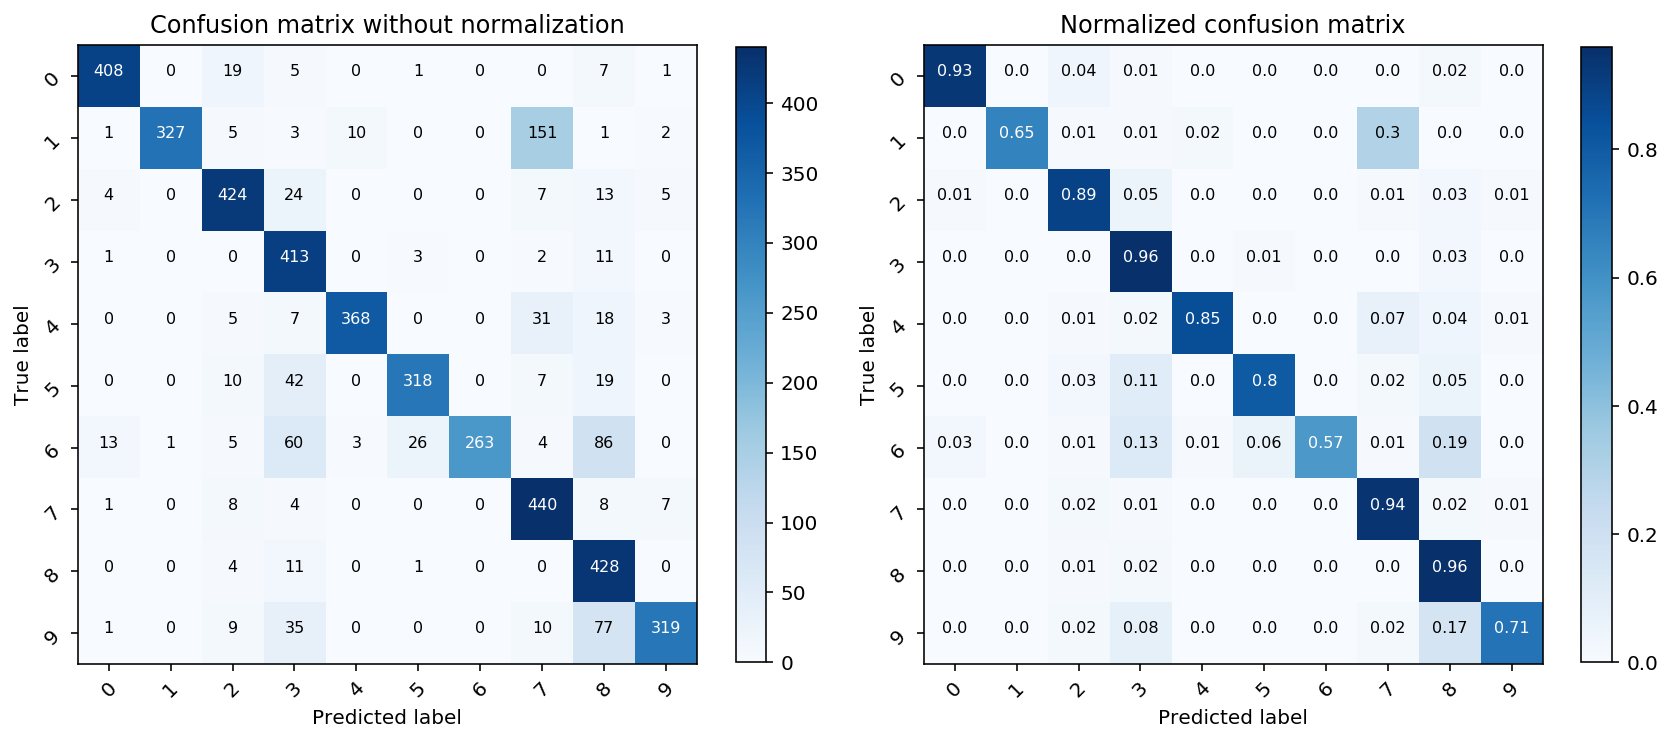

In [23]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_unlabel2_true.argmax(axis=-1), y_predict2)
plot_confusion_matrix(cnf_matrix, classes=class_labels, 
                      cmap=plt.cm.Blues,
                      save_path=model_name)

### Build and fit Student1

In [22]:
batch_size  = 128
epochs      = 20
model_name  = f'studentmodel1_1000i_Mnist_{epochs}e_drop05_R{R}_augv3' 

model = build_model(img_size, 'ENB0', drop_rate, 1)
    
model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])



#Save the model after every 5 epoch.
maxacc_filepath = './models/'+ model_name +'-{epoch:02d}-{val_categorical_accuracy:.2f}_{val_f1_m:.2f}.hdf5' 

checkpoint1 = ModelCheckpoint(filepath=maxacc_filepath, monitor='val_categorical_accuracy',
                              verbose=1, save_best_only=False, period=15) #wwz

callbacks_list = [checkpoint1]

H_student1 = model.fit_generator(aug_student.flow(x_train2, y_train2, batch_size=batch_size),
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train2) // batch_size,
                        validation_data  = aug_validation.flow(x_valid2, y_valid2, batch_size=batch_size),
                        validation_steps = len(x_valid2)// batch_size,
                        callbacks        = callbacks_list,
                        verbose=0) # only get output metrics for validation data  

True
16/16 [==============================] - 5s 318ms/step - loss: 0.2908 - categorical_accuracy: 0.9046 - f1_m: 0.9114

Epoch 00015: saving model to ./models/studentmodel1_1000i_Mnist_20e_drop05_R5.5_augv3-15-0.90_0.91.hdf5
16/16 [==============================] - 5s 305ms/step - loss: 0.3005 - categorical_accuracy: 0.9036 - f1_m: 0.8966


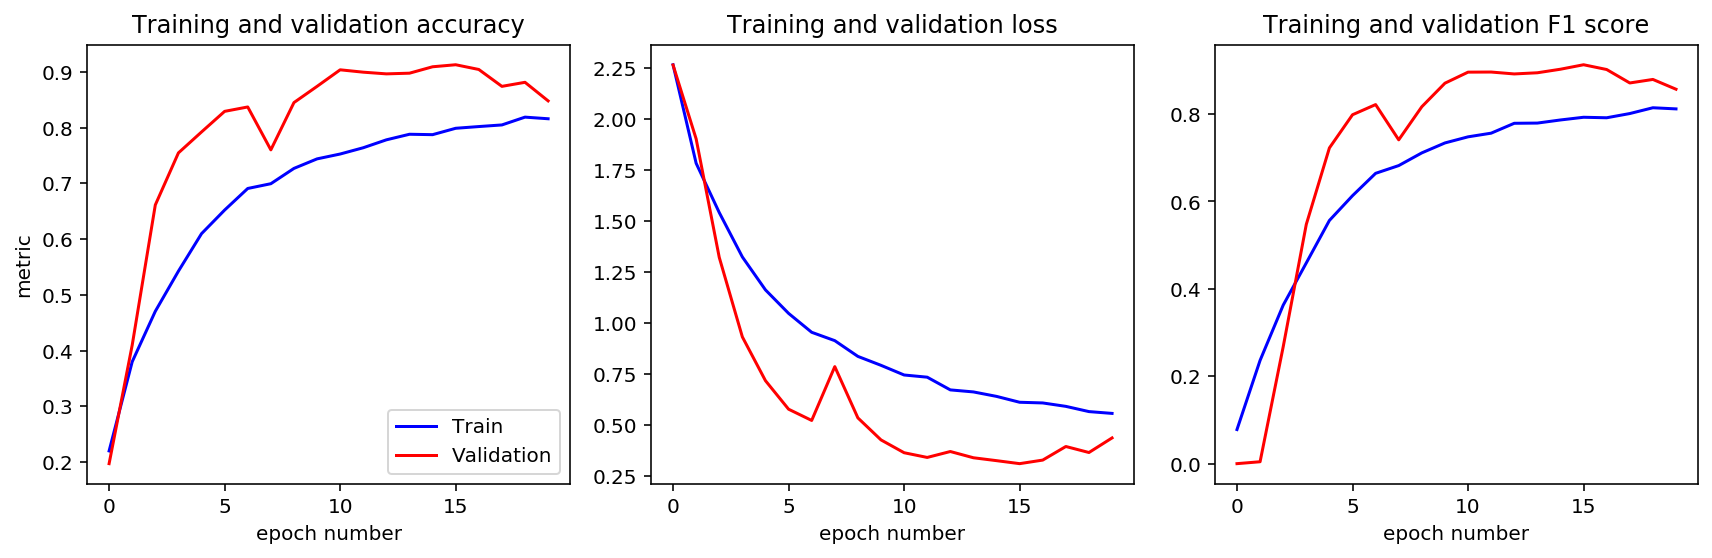

In [21]:
save_and_plot(model, model_name, H_student1)

Based on above figure, the recommended epoch number for student1 is about 20-30.

**Should we decrease the learning rate?**

### Prepare data for student2 - generate psuedo labels and combine last step train data and new unlabeled data 

In [19]:
# Student2 model
num_label   = 1000
num_label   = num_label*(1+R)
num_unlabel = R*num_label

# select new unlabeled data from unused data(x_unused,y_unused)
x_unlabel3, x_unused3, y_unlabel3_true, y_unused3 = train_test_split(x_unused2,y_unused2, train_size=int(num_unlabel), random_state=31,shuffle=True)

if int((num_label+num_unlabel)*0.3) < x_unused3.shape[0]:
    x_valid3,   x_unused4, y_valid3,   y_unused4 = train_test_split(x_unused3,y_unused3, train_size=int((num_label+num_unlabel)*0.3), random_state=31, shuffle=True)
    del x_unused4, y_unused4
else:
    x_valid3, y_valid3 = x_unused3, y_unused3



# Update old unlabeled data (y_unlabel2) & generate new unlabeled data(y_label3) using student1 model
student1_model_name = 'studentmodel1_1000i_Mnist_20e_drop05_R4.5_augv3-15-0.91_0.90'#model_name
student1_model, y_unlabel2_st1, y_predict2_st1 = pesodu_label_generator(student1_model_name, x_unlabel2)
print('Finished updating old psuedo labels')
student1_model, y_unlabel3_st1, y_predict3_st1 = pesodu_label_generator(student1_model_name, x_unlabel3)
print('Finished generating new psuedo labels')

Finished updating old psuedo labels
Finished generating new psuedo labels


In [20]:
# combine unlabeled & labeled data
# Firstly combine x_train1 & x_unlabel2, then add x_unlabel3
x_train3 = np.concatenate((x_train1,x_unlabel2,    x_unlabel3),axis=0)
y_train3 = np.concatenate((y_train1,y_unlabel2_st1,y_unlabel3_st1),axis=0)


del x_unused2,y_unused2

print('Student2 model data preprocessing finished.')
print(x_train3.shape[0], 'train samples;  ',x_valid3.shape[0], 'validation samples')

Student2 model data preprocessing finished.
30250 train samples;   9075 validation samples


Confusion matrix, without normalization
Normalized confusion matrix


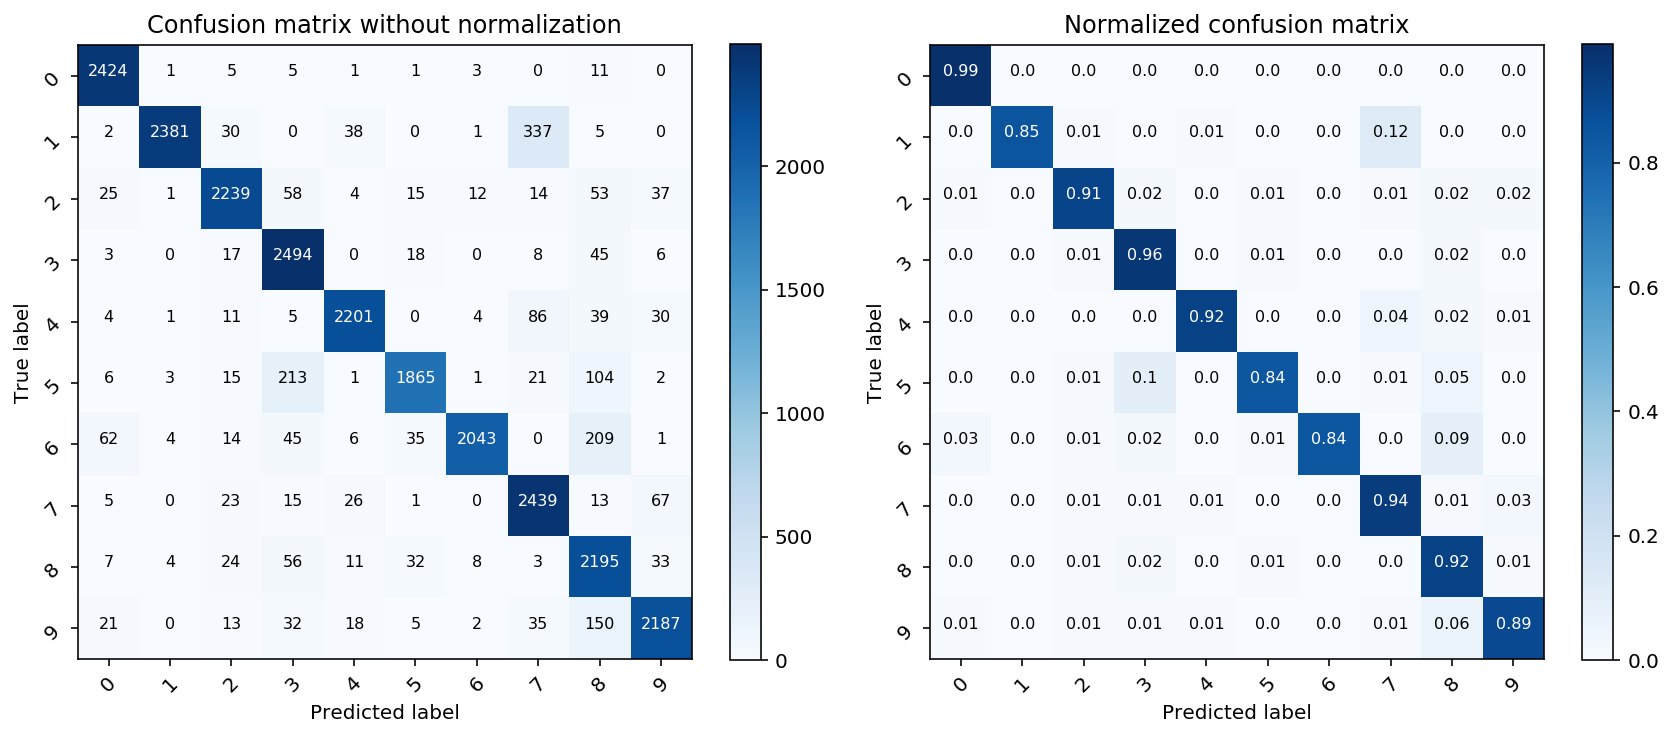

In [24]:
cnf_matrix = confusion_matrix(y_unlabel3_true.argmax(axis=-1), y_predict3_st1)
plot_confusion_matrix(cnf_matrix, classes=class_labels, 
                      cmap=plt.cm.Blues,
                      save_path=model_name)

### Build and fit Student2

In [24]:
batch_size  = 128
epochs      = 20
model_name  = f'studentmodel2_1000i_Mnist_{epochs}e_drop05_R{R}_augv3'

model = build_model(img_size, base_model_type, drop_rate, intermediate_dense_num)
    
model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])



#Save the model after every 5 epoch.
maxacc_filepath = './models/'+ model_name +'-{epoch:02d}-{val_categorical_accuracy:.2f}_{val_f1_m:.2f}.hdf5' 

checkpoint1 = ModelCheckpoint(filepath=maxacc_filepath, monitor='val_categorical_accuracy',
                              verbose=1, save_best_only=False, period=5) #wwz

callbacks_list = [checkpoint1]

H_student2 = model.fit_generator(aug_student.flow(x_train3, y_train3, batch_size=batch_size),
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train3) // batch_size,
                        validation_data  = aug_validation.flow(x_valid3, y_valid3, batch_size=batch_size),
                        validation_steps = len(x_valid3)// batch_size,
                        callbacks        = callbacks_list,
                        verbose=0) # only get output metrics for validation data  

True
86/86 [==============================] - 26s 304ms/step - loss: 0.1302 - categorical_accuracy: 0.9598 - f1_m: 0.9594

Epoch 00005: saving model to ./models/studentmodel2_1000i_Mnist_20e_drop05_R6_augv3-05-0.96_0.96.hdf5
86/86 [==============================] - 26s 305ms/step - loss: 0.1644 - categorical_accuracy: 0.9447 - f1_m: 0.9439

Epoch 00010: saving model to ./models/studentmodel2_1000i_Mnist_20e_drop05_R6_augv3-10-0.94_0.94.hdf5
86/86 [==============================] - 26s 301ms/step - loss: 0.1566 - categorical_accuracy: 0.9491 - f1_m: 0.9473

Epoch 00015: saving model to ./models/studentmodel2_1000i_Mnist_20e_drop05_R6_augv3-15-0.95_0.95.hdf5
86/86 [==============================] - 26s 300ms/step - loss: 0.1604 - categorical_accuracy: 0.9481 - f1_m: 0.9482

Epoch 00020: saving model to ./models/studentmodel2_1000i_Mnist_20e_drop05_R6_augv3-20-0.95_0.95.hdf5


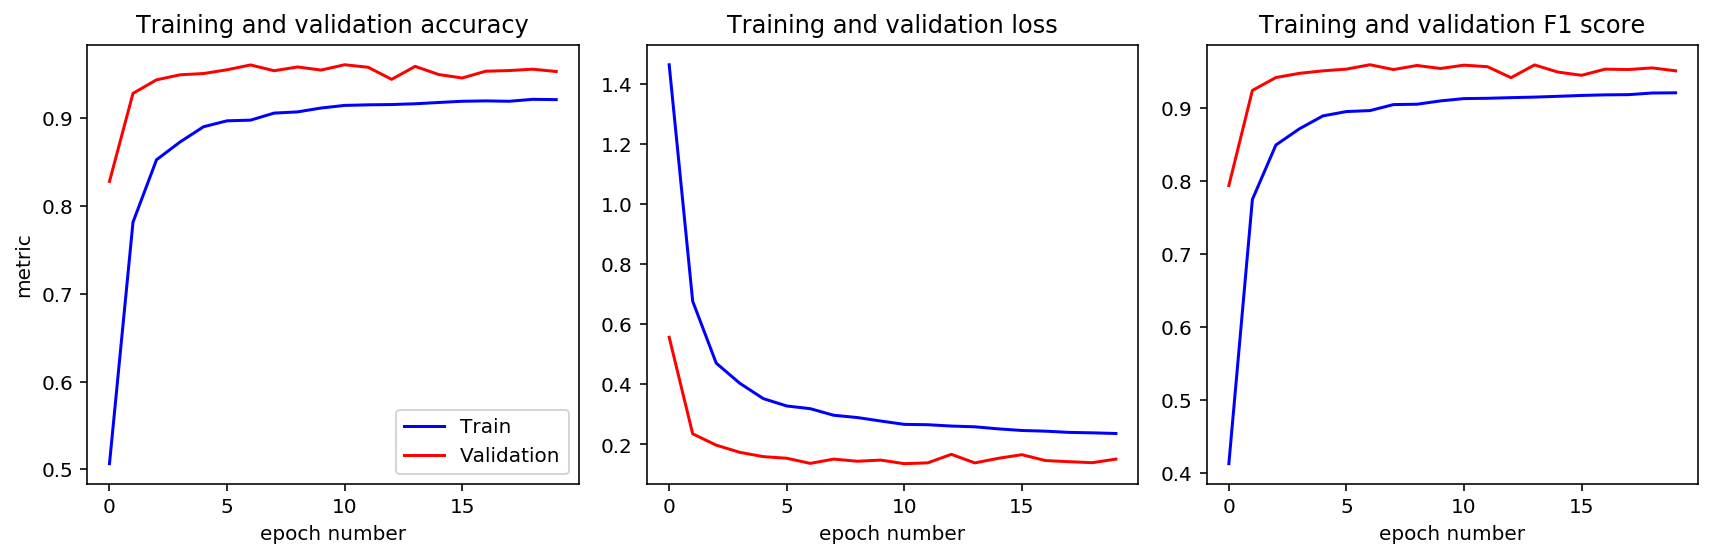

In [27]:
save_and_plot(model, model_name, H_student2)

**Should we decrease learning rate here?**

### Final evalution of the three models on test data

In [28]:
# Do not use all test data, 2000 test images will be enough
# y_test1 is preprocessed already
x_test, x_test_unused, y_test, y_test_unused = train_test_split(x_test1, y_test1, train_size=2000, random_state=31, shuffle=True)

In [29]:
model1_name = teacher_model_name 
model2_name = student1_model_name 
model3_name = model_name #'studentmodel2_1000i_Mnist_20e_drop05_R5.5_augv3-05-0.95_0.94' # #'studentmodel2_1000i_Mnist_20e_drop05_R6_augv3-05-0.96_0.96' # 

model1, y_pred1, y_proba1 = pesodu_label_generator(model1_name, x_test)
model2, y_pred2, y_proba2 = pesodu_label_generator(model2_name, x_test)
model3, y_pred3, y_proba3 = pesodu_label_generator(model3_name, x_test)

y_pred1 = y_pred1.argmax(axis=-1)
y_pred2 = y_pred2.argmax(axis=-1)
y_pred3 = y_pred3.argmax(axis=-1)
y_test  = y_test.argmax(axis=-1)

print('Test data prediction finished.')

Test data prediction finished.


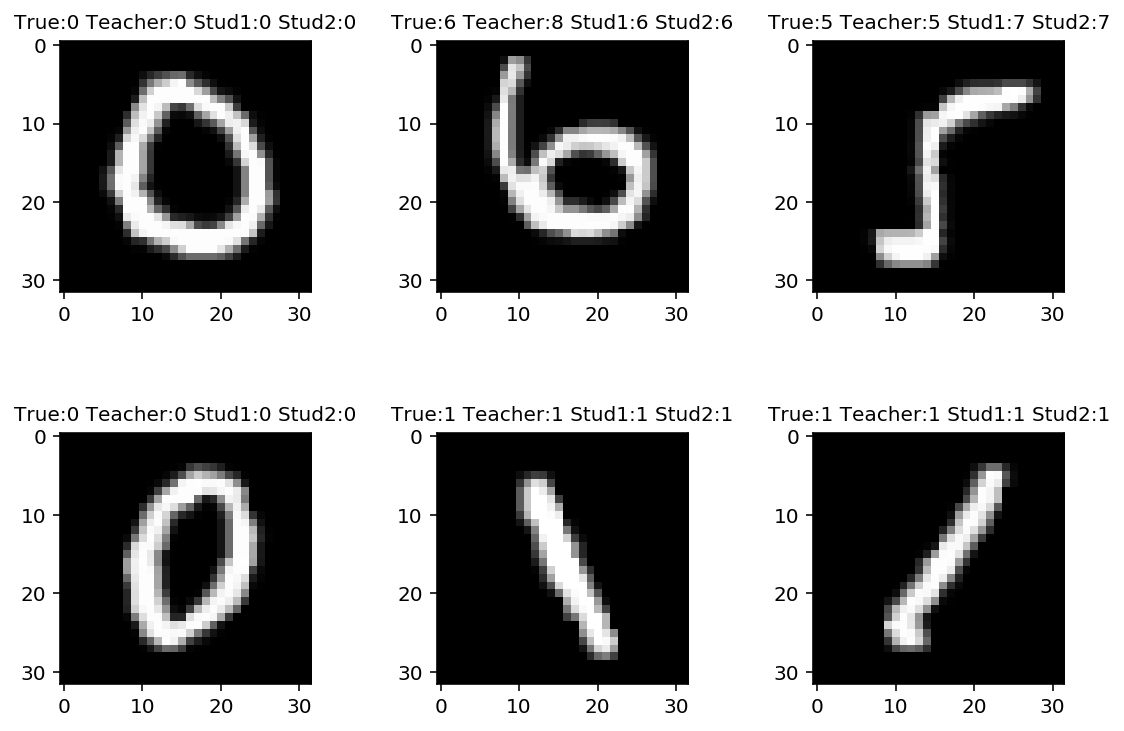

In [30]:
from random import seed
from random import randint

# seed random number generator
seed(31)

fig, axes = plt.subplots(figsize=(9,6),ncols=3, nrows=2)

# generate 6 integers
i = 0
j = 0 
for k in range(6):
    value = randint(0,x_test.shape[0])
    axes[i,j].imshow(x_test[value])
    
    pre_label1 = y_pred1[value]
    pre_label2 = y_pred2[value]
    pre_label3 = y_pred3[value]
    true_label = y_test[value]
    
    axes[i,j].set_title(f'True:{true_label} '+f'Teacher:{pre_label1} '+f'Stud1:{pre_label2} '+f'Stud2:{pre_label3}', fontsize=10)
    
    if j==2:
        j = 0
        i += 1
    else: 
        j += 1

plt.subplots_adjust(wspace=0.5, hspace=0.5) # adjust the space between axes

#### Test Top1 Accuracy, Balanced Accuracy and F1 Score

In [31]:
# plot three accuracy and f1 score on test data on the same plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

def plot_f1_acc_on_test(y_test, y_pred1, y_pred2, y_pred3, save_path=None):
    fig, ax = plt.subplots(figsize=(7,5))
    
    f1_1 = f1_score(y_test, y_pred1, labels=None, average='weighted')
    f1_2 = f1_score(y_test, y_pred2, labels=None, average='weighted')
    f1_3 = f1_score(y_test, y_pred3, labels=None, average='weighted')
    
    ba1 = balanced_accuracy_score(y_test, y_pred1)
    ba2 = balanced_accuracy_score(y_test, y_pred2)
    ba3 = balanced_accuracy_score(y_test, y_pred3)
    
    acc1 = accuracy_score(y_test, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    acc3 = accuracy_score(y_test, y_pred3)
    
    model = list(range(0,3))    
    model_name = ['Teacher','Student1','Student2']
    
    acc = [acc1, acc2, acc3]
    f1 = [f1_1, f1_2, f1_3]
    ba = [ba1, ba2, ba3]
        
#     ax.scatter(model, f1, c = 'r', marker = 'o', s = 3, label='F1 score')
#     ax.scatter(model, acc, c = 'g', marker = 'o', s = 3, label='Accuracy')
    
    ax.plot(model, f1, c = 'r', marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='F1 score')
    ax.plot(model, acc, c = 'g', marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Top1 Accuracy')
    ax.plot(model, ba, c = 'b', marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Balanced Accuracy')
    
    ax.legend()
    ax.set_xlabel('model name')
    ax.set_ylabel('metric')
    ax.set_title('Scores of Three Models on Test Data')
    ax.set_xticks(model)
    ax.set_xticklabels(model_name, rotation=45)
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/f1_acc_test_'+save_path+'.png')

    plt.show()

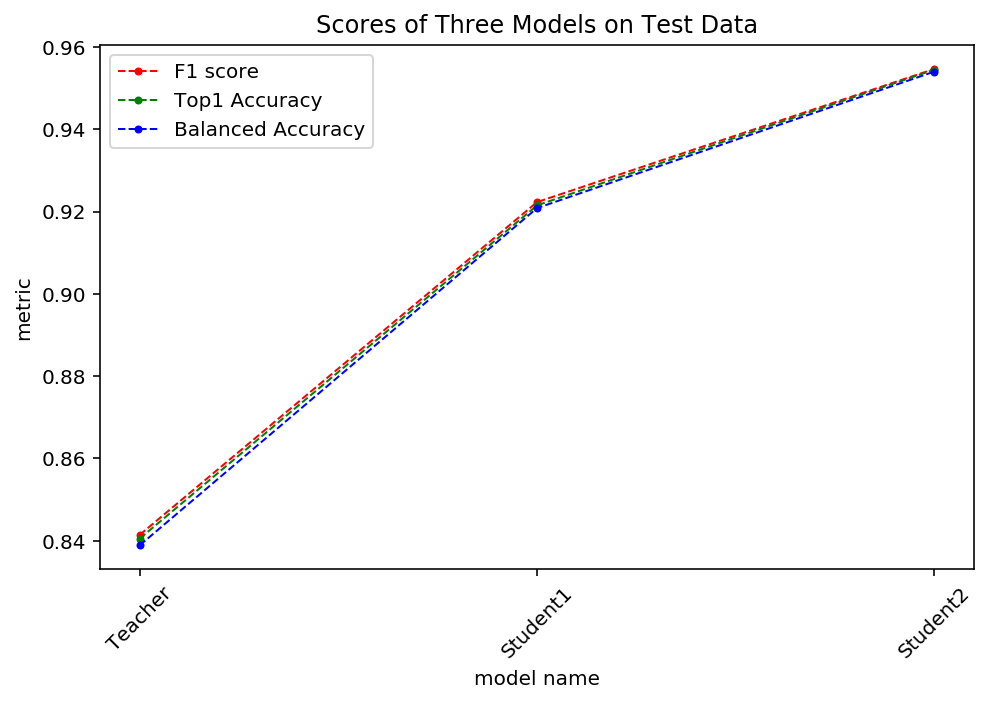

In [32]:
case_name = f'R{R}_Mnist_augv2'
plot_f1_acc_on_test(y_test, y_pred1, y_pred2, y_pred3, save_path=case_name)

In [33]:
f1_score(y_test, y_pred3, labels=None, average='weighted')

0.9546778739506326

Save the prediction results on test set

In [34]:
np.save('./predictions/x_test_Mnist.npy', x_test)
np.save('./predictions/y_test_Mnist.npy', y_test) 
# prediction results
np.save(f'./predictions/y_teacher_R{R}_30e_augv3.npy', y_pred1) 
np.save(f'./predictions/y_student1_R{R}_20e_augv3.npy', y_pred2) 
np.save(f'./predictions/y_student2_R{R}_20e_augv3.npy', y_pred3) 

#### Confusion Matrix

In [35]:
# fig, axes = plt.subplots(figsize=(8,4),ncols=2)
def plot_confusion_matrix_3(cm1, cm2, cm3, classes, cmap=plt.cm.Blues, save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    fig, axes = plt.subplots(figsize=(18,6),ncols=3)
    
    # normalized
    cm1 = np.around(cm1,decimals=2)
    cm2 = np.around(cm2,decimals=2)
    cm3 = np.around(cm3,decimals=2)
    
    im_1 = axes[0].imshow(cm1, interpolation='nearest', cmap=cmap)
    axes[0].set_title('Teacher')
    fig.colorbar(im_1,ax=axes[0],shrink=0.75)

    thresh = cm1.max() / 2.
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            axes[0].text(j, i, cm1[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm1[i, j] > thresh else "black")
    
    im_2 = axes[1].imshow(cm2, interpolation='nearest', cmap=cmap)
    axes[1].set_title('Student1')
    fig.colorbar(im_2,ax=axes[1],shrink=0.75)

    thresh = cm2.max() / 2.
    for i in range(cm2.shape[0]):
        for j in range(cm2.shape[1]):
            axes[1].text(j, i, cm2[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm2[i, j] > thresh else "black")

    im_3 = axes[2].imshow(cm3, interpolation='nearest', cmap=cmap)
    axes[2].set_title('Student2')
    fig.colorbar(im_3,ax=axes[2],shrink=0.75)

    thresh = cm3.max() / 2.
    for i in range(cm3.shape[0]):
        for j in range(cm3.shape[1]):
            axes[2].text(j, i, cm3[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm3[i, j] > thresh else "black")
            
    tick_marks = np.arange(len(classes))
    
    for ax in axes:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, rotation=45)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    fig.suptitle('Confusion Matrix for Three Models on Test Data')
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_test_'+save_path+'.png')

    plt.show()

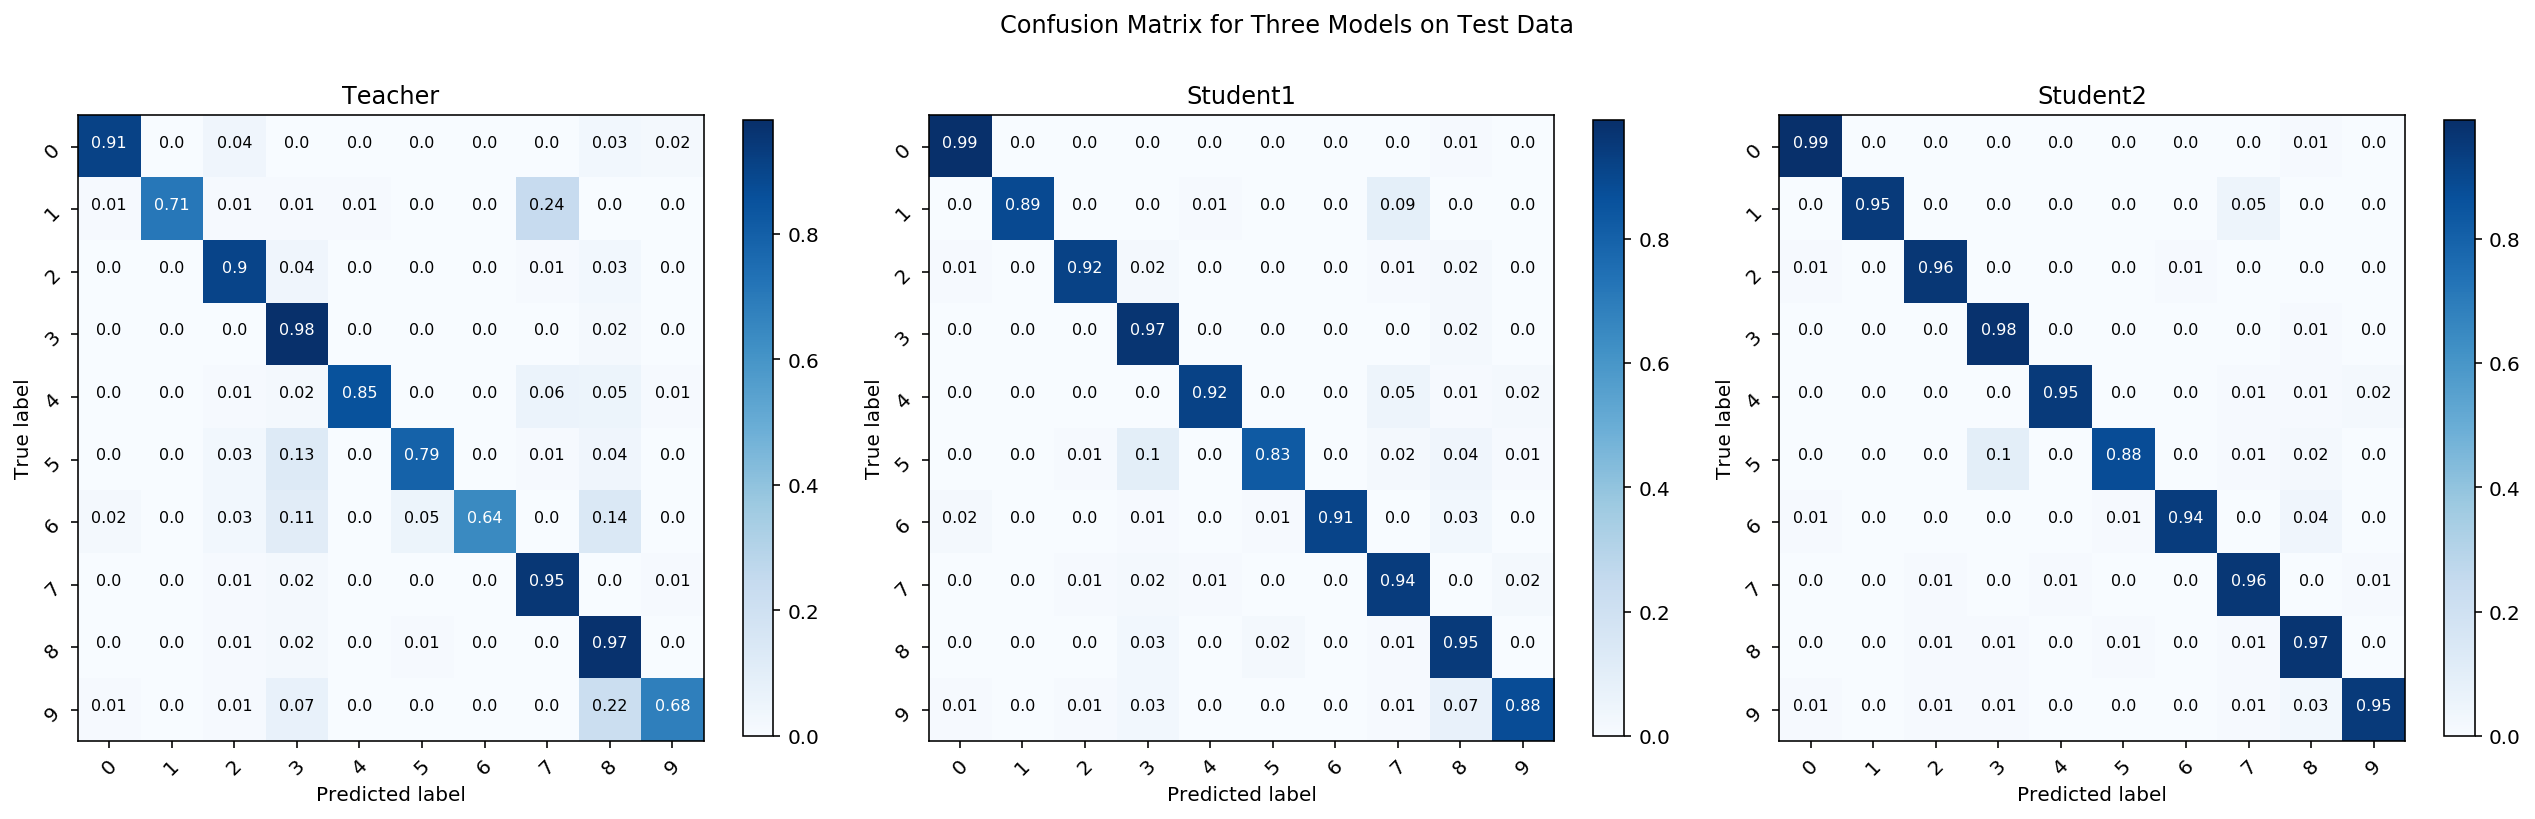

In [36]:
cnf_matrix1 = confusion_matrix(y_test, y_pred1, normalize='true')
cnf_matrix2 = confusion_matrix(y_test, y_pred2, normalize='true')
cnf_matrix3 = confusion_matrix(y_test, y_pred3, normalize='true')
cm_plt = plot_confusion_matrix_3(cnf_matrix1, cnf_matrix2, cnf_matrix3, class_labels, cmap=plt.cm.Blues, save_path=case_name)